# LAB 1 - Introduction to digital images and neural networks

In this hands-on we will learn how to apply simple image transformations, and how to design neural networks for image classification tasks. 

## Part 1: Digital Images warm up  

This is a summary of basic image concepts, where we will learn how to<br>
- Load an image
- Extract the R,G,B components
- Compute the histograms
- Apply geometric transformations


In [1]:
#import libraries
import math
import numpy as np   
import matplotlib.pyplot as plt
%matplotlib inline

# skimage - image processing library
from skimage import draw as drw
from skimage import data, io, color, exposure, img_as_float, img_as_ubyte, transform 
from skimage import color

Load a sample image

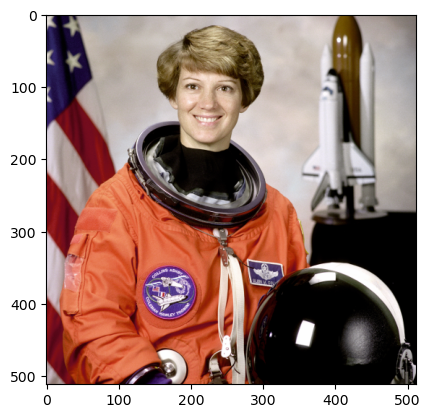

In [2]:
astro = data.astronaut() # image available in skimage

# visualize it
plt.imshow(astro)

Can you guess data type and shape of this image?

In [3]:
print("image data type is: {}".format(type(astro)))
print("image shape is: {}".format(astro.shape))

image data type is: <class 'numpy.ndarray'>
image shape is: (512, 512, 3)


As expected, an *RGB* image is stored in memory as a three dimensional array ($shape = rows \times columns \times channels$). The intensities of each color channel are saved in a separate matrix.

Do you know how to slice a <font face="TrueType">numpy.array</font>? We now extract the three color channels from an image of choice and print their shape.

In [4]:
R = astro[:,:,0]
G = astro[:,:,1]
B = astro[:,:,2]
print("R shape is: {}".format(R.shape))
print("G shape is: {}".format(G.shape))
print("B shape is: {}".format(B.shape))

R shape is: (512, 512)
G shape is: (512, 512)
B shape is: (512, 512)


Let's try to inspect the content of a channel, for instance printing the first 5 elements of the first 3 lines of the red one.

It looks like an image is stored in memory as a matrix filled with integer numbers. Can you guess the right range? Check it out in the next box.

Hint: you can use <font face="TrueType">np.max</font> and <font face="TrueType">np.min</font> on any input <font face="TrueType">numpy.array</font>.

In [5]:
print("Max value for the red channel: {}".format(np.max(R)))
print("Min value for the red channel: {}".format(np.min(R)))

Max value for the red channel: 255
Min value for the red channel: 0


We now visualize the three channels in separate figures. In which channel do you expect the astronaut suit will have highest values?


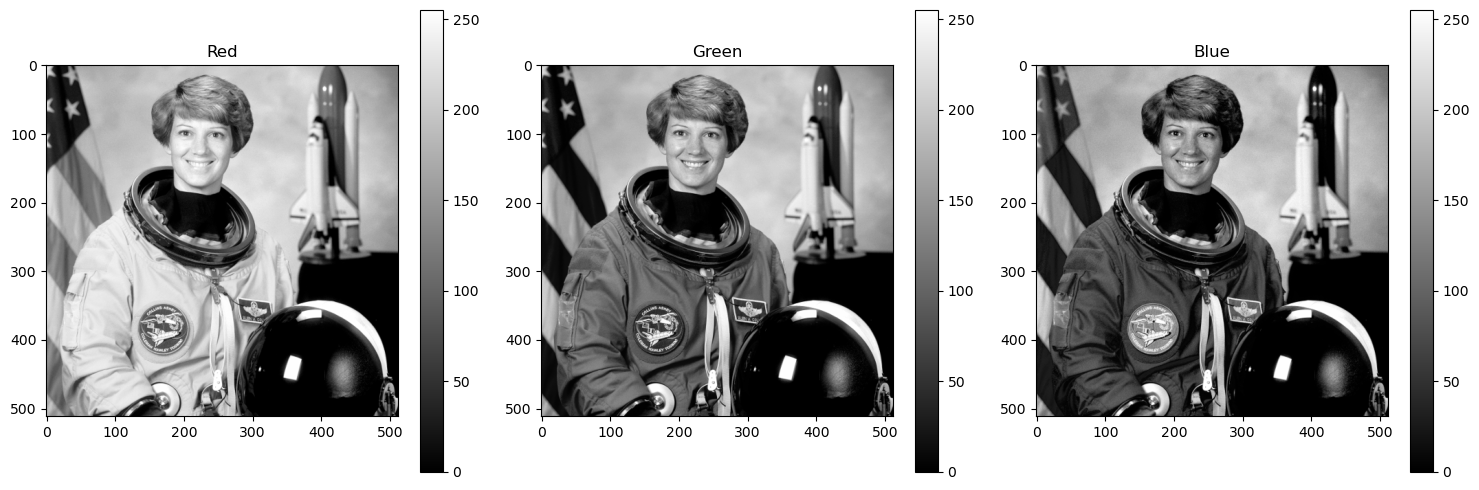

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow((R),cmap='gray');
plt.colorbar(orientation='vertical')
plt.title('Red')

plt.subplot(1,3,2)
plt.imshow((G),cmap='gray');
plt.title('Green')
plt.colorbar(orientation='vertical')

plt.subplot(1,3,3)
plt.imshow((B),cmap='gray');
plt.title('Blue')
plt.colorbar(orientation='vertical')

plt.tight_layout() # a handy command that increases spacing between subplots

### Color histograms
We now visualize the color histograms. They tell us how many pixels have a given value of intensity in each color channel. This information is somehow representative of the image: for example, in case of the given image, the red histogram has a peak at high intensity values since the orange suit occupies many pixels. Anyhow such histograms do not carry structural information of the image.

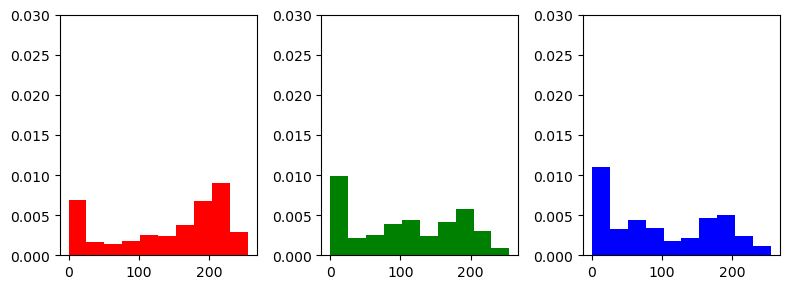

In [7]:
plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.hist(R.ravel(), density=True, color='r');
plt.ylim([0,0.03])


plt.subplot(1,3,2)
plt.hist(G.ravel(), density=True, color='g');
plt.ylim([0,0.03])

plt.subplot(1,3,3)
plt.ylim([0,0.03])
plt.hist(B.ravel(), density=True, color='b');

plt.tight_layout() # a handy command that increases spacing between subplots

<b>You can play with the number of bins of the histograms. To change it use for instance <br><tt> plt.hist(R.ravel(), bins=100, density=True, color='r'); </tt></b>

### From RGB to grayscale

As said, a color image is a collection of three matrices, each one representing a different color channel. How can we represent a grayscale image? How many *color channels* do we need? It is possible to encode a color image in grayscale using the following linear transformation:

$Y = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B$

*The coefficients represent the measured intensity perception of typical trichromat humans, depending on the primaries being used; in particular, human vision is most sensitive to green and least sensitive to blue.* [cit. <a href="https://en.wikipedia.org/wiki/Grayscale">Wikipedia</a>]

The <a href="http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2gray"><font face="TrueType">color.rgb2gray</font></a> function performs this operation and combines the three channels in a grayscale encoding.

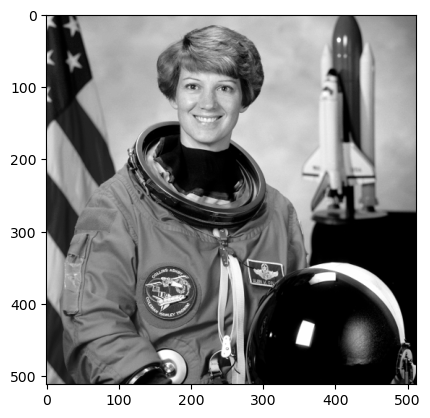

In [8]:
gray_astro = color.rgb2gray(astro)
plt.imshow(gray_astro, cmap='gray');

### Geometric transformations
Finally, let's have a look at geometric transformations. The example shown here is a rototranslation.

Note: Similar transformations are commonly used in deep learning to perform data augmentation, which helps preventing overfitting of the model, more information on Wednesday.

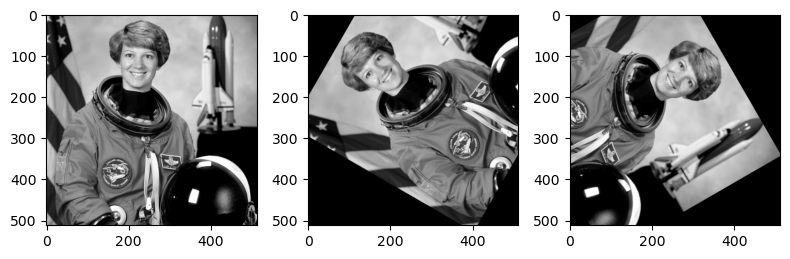

In [9]:
tform = transform.SimilarityTransform(scale=1, rotation=math.pi/3,
                                      translation=(gray_astro.shape[0]/2, -100))

rotated = transform.warp(gray_astro, tform)
back_rotated = transform.warp(gray_astro, tform.inverse)

plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.imshow(gray_astro, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(rotated, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(back_rotated, cmap=plt.cm.gray)

plt.tight_layout()

# Part 2: [Deep] Neural Network


In this second part we will:
*  Import a dataset
*  [Optionally] Extract Features (for example color histograms)
*  Build a model
*  Train the model 
*  Evaluate the model
*  Assess train, validation and test accuracy, and reason on overfitting

In [10]:
# import some libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## **Learning from RGB images**

To start, we will use raw pixels to teach the network how to classify the images (we hence avoid the optional point by now).

### Import an pre-process the dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Classes include *Airplane*, Automobile, Bird, Cat, Deer, 
               Dog, Frog, Horse, Ship, Truck.<br>



In [11]:
# load the dataset
num_classes = 10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
cifar10 = tf.keras.datasets.cifar10
(x_learn, y_learn),(x_test, y_test) = cifar10.load_data()


# Normalize the data in [0 1]
print("Normalizing training set..")
x_learn = np.asarray(x_learn, dtype=np.float32) / 255 # Normalizing training set
print("Normalizing test set..")
x_tlinest = np.asarray(x_test, dtype=np.float32) / 255 # Normalizing test set

Normalizing training set..
Normalizing test set..


In [12]:
# split in training and validation
x_train, x_val, y_train, y_val = train_test_split(x_learn, y_learn, test_size=0.25, random_state=12)

In [13]:
# Standardizing the data
def standardize_dataset(X):
    image_means = []
    image_stds = []

    for image in X:
        image_means.append(np.mean(image)) # Computing the image mean
        image_stds.append(np.std(image)) # Computing the image standard deviation

    dataset_mean = np.mean(image_means) # Computing the dataset mean
    dataset_std = np.mean(image_stds) # Computing the dataset standard deviation
    return [dataset_mean, dataset_std] # For every image we subtract to it the dataset mean and we divide by the dataset standard deviation

dataset_mean, dataset_std = standardize_dataset(x_train)

print("Standardizing training set..")
x_train = (x_train-dataset_mean)/dataset_std # Standardizing the training set
print("Standardizing validation set..")
x_val = (x_val-dataset_mean)/dataset_std # Standardizing the test set
print("Standardizing test set..")
x_test = (x_test-dataset_mean)/dataset_std # Standardizing the test set

# one hot encode target values
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print("Size of the training set")
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("Size of the validation set")
print("x_val", x_val.shape)
print("y_val", y_val.shape)

print("Size of the test set")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

Standardizing training set..
Standardizing validation set..
Standardizing test set..
Size of the training set
x_train (37500, 32, 32, 3)
y_train (37500, 10)
Size of the validation set
x_val (12500, 32, 32, 3)
y_val (12500, 10)
Size of the test set
x_test (10000, 32, 32, 3)
y_test (10000, 10)


Plot some sample from the training set

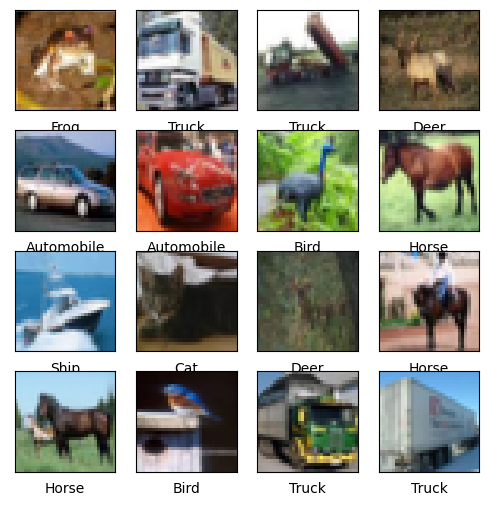

In [14]:
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_learn[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_learn[i,0]])
plt.show()

### Build a Model

Build a model with this structure: Flatten+Dense(ReLU)+ ... + +Dense(softmax). 


In [15]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(Flatten())

# you may add here additional dense layers, using fo instance model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))

# Add a Dense layer with number of neurons equal to the number of classes, with softmax as activation function
model.add(Dense(num_classes, activation='softmax'))

Metal device set to: Apple M1


2024-06-10 14:58:48.508945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 14:58:48.509447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


When we are building a model there are many design choises that we must operate: the choice of a Loss Function, the Metrics and the Optimizer.<br>

**Loss functions** are used to compare the network's predicted output  with the real output, in each pass of the backpropagations algorithm<br>
Common loss functions are: mean-squared error, cross-entropy, and so on...<br><br>
**Metrics** are used to evaluate a model; common metrics are precision, recall, accuracy, auc,..<br>

The **Optimizer** determines the update rules of the weights. The performance and update speed may heavily vary from optimizer to optimizer; in choosing an optimizer what's important to consider is the network depth, the type of layers and the type of data.<br>
The gif below give an idea on how different Optimizers work.<br>

<img src="https://user-images.githubusercontent.com/11681225/49325458-fc785480-f585-11e8-8d2a-9012d6024c6e.gif" width="460px">

Configure the model for training

In [16]:
# Optimizers    https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, Adamax, RMSprop  # TODO: grub from 'legacy' in new tf version
from tensorflow.keras.optimizers.experimental import Nadam  # TODO:  grub from 'experimental' in new tf version

adam = Adam(learning_rate=0.001)

# Losses    https://keras.io/losses/
loss = ['categorical_crossentropy']

# Metrics    https://www.tensorflow.org/api_docs/python/tf/metrics
metrics = ['accuracy','precision','recall']

In [17]:
# Compile the model you created before using 
# adam optimizer as optimizer
# categorical crossentropy as loss function
# accuracy as metric
model.compile(optimizer=adam,
              loss=loss[0],
              metrics=[metrics[0]])

### Train the model 

The batch size is a number of samples processed before the model is updated.<br>
The number of epochs is the number of complete passes through the training dataset.

In [18]:
batch_size = 128
epochs = 20
# fit your model and save the returned value as "history". 
# Use both the train and validation set 
# Set both properly the batch size value and the epochs value
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data =(x_val, y_val), epochs=epochs)

Epoch 1/20


2024-06-10 14:59:00.806340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - 5s 12ms/step - loss: 1.9568 - accuracy: 0.3320 - val_loss: 1.8200 - val_accuracy: 0.3782
Epoch 2/20
293/293 [==============================] - 3s 10ms/step - loss: 1.7394 - accuracy: 0.3942 - val_loss: 1.7459 - val_accuracy: 0.3933
Epoch 3/20
293/293 [==============================] - 3s 10ms/step - loss: 1.6496 - accuracy: 0.4225 - val_loss: 1.6908 - val_accuracy: 0.4116
Epoch 4/20
293/293 [==============================] - 3s 10ms/step - loss: 1.5999 - accuracy: 0.4352 - val_loss: 1.6536 - val_accuracy: 0.4190
Epoch 5/20
293/293 [==============================] - 3s 11ms/step - loss: 1.5630 - accuracy: 0.4491 - val_loss: 1.6448 - val_accuracy: 0.4248
Epoch 6/20
293/293 [==============================] - 3s 10ms/step - loss: 1.5396 - accuracy: 0.4548 - val_loss: 1.6151 - val_accuracy: 0.4254
Epoch 7/20
293/293 [==============================] - 3s 12ms/step - loss: 1.5168 - accuracy: 0.4623 - val_loss: 1.6219 - val_accuracy: 0.4297
Epoch 8/20

Training history visualization



In [19]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
  

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

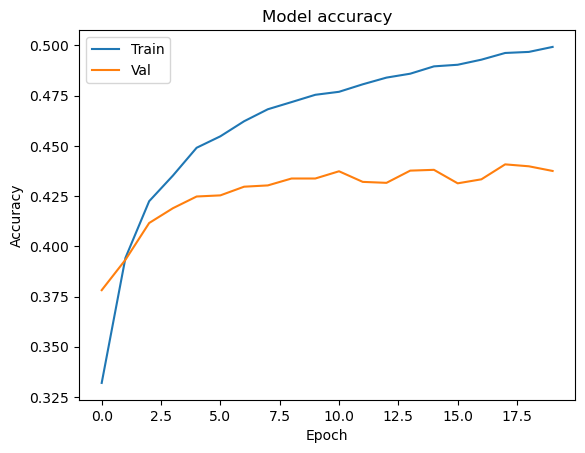

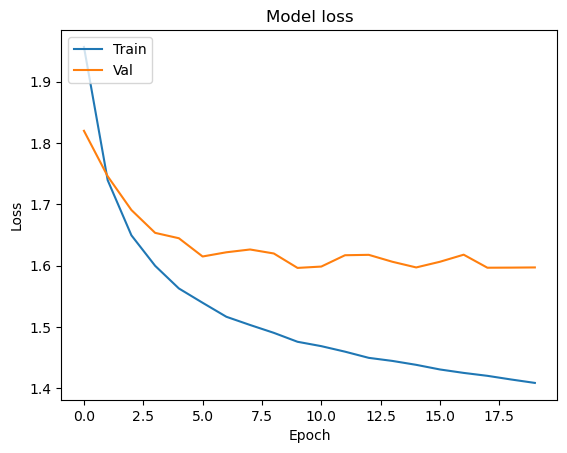

In [20]:
plot_history(history)

### Evaluate the model


In [21]:
_, train_acc = model.evaluate(x_train, y_train, verbose=1)
_, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 444.9775 - accuracy: 0.2957
Train: 0.509, Test: 0.296


<b>You may want to play with the structure of the network, for instance by changing the number of layers and of the neurons inside each layer. Also, you might play with the choice of the non-linear activation function</b>

## **Learning from color histograms**

In this scenario, we will experiment with a feature-extraction-based approach, where the neural network will process image color histograms rather than the raw pixels (as in the previous case).
Image histograms represent global color information of the image, and are expected to perform well only in limited cases (where this kind of information is enough to distinguish different classes).


### Import and pre-process the dataset
First, we need to import and pre-process the dataset, in order to extract the histograms.

For simiplicity we will use the default number of bins (10) and build the histogram for each of the color channels independently.

This results in feature vector having 30 elements for each image.

In [22]:
# load the dataset
num_classes = 10 
cifar10 = tf.keras.datasets.cifar10
(x_learn, y_learn),(x_test, y_test) = cifar10.load_data()
# note that it is not required to normalize the pixel intensities anymore

hist_learn = []
hist_test = []
num_pixels = np.prod(x_learn[0].shape[:2])  # 32*32, the dimensions of CIFAR10 images
for sample_learn in x_learn:
    hist_learn.append(np.concatenate([np.histogram(sample_learn[:,:,0].ravel())[0]/num_pixels,
                                    np.histogram(sample_learn[:,:,1].ravel())[0]/num_pixels,
                                    np.histogram(sample_learn[:,:,2].ravel())[0]/num_pixels]))
    
for sample_test in x_test:
    hist_test.append(np.concatenate([np.histogram(sample_test[:,:,0].ravel())[0]/num_pixels,
                                   np.histogram(sample_test[:,:,1].ravel())[0]/num_pixels,
                                   np.histogram(sample_test[:,:,2].ravel())[0]/num_pixels]))

hist_learn = np.array(hist_learn)
hist_test = np.array(hist_test)


print(hist_learn.shape)

(50000, 30)


Split the dataset (after preprocessing)

In [23]:
x_train_hist, x_val_hist, y_train, y_val = train_test_split(hist_learn, y_learn, test_size=0.25, random_state=12)

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print("Size of the training set")
print("x_train", x_train_hist.shape)
print("y_train", y_train.shape)

print("Size of the validation set")
print("x_val", x_val_hist.shape)
print("y_val", y_val.shape)

print("Size of the test set")
print("x_test", hist_test.shape)
print("y_test", y_test.shape)

Size of the training set
x_train (37500, 30)
y_train (37500, 10)
Size of the validation set
x_val (12500, 30)
y_val (12500, 10)
Size of the test set
x_test (10000, 30)
y_test (10000, 10)


### Build a Model
The model structure needs to change in this case. Can you guess the input dimensions?

You might also want to change the number and the dimensions of the hidden layers, to account for the dimensionality reduction 

In [26]:
# ...insert your code here ...
# A possible structure for the networks is
# one hidden layer with 16 neurons and relu
model_features = Sequential()
model_features.add(Dense(16, activation='relu'))

# one hidden layer with 8 neurons ans relu
model_features.add(Dense(8, activation='relu'))

# output layer with softmax
model_features.add(Dense(10, activation='softmax'))

In [27]:
# Compile the model, and run the fitting
adam = Adam(learning_rate=0.001)
model_features.compile(optimizer=adam,
              loss=loss[0],
              metrics=[metrics[0]])

### Train and evaluate the model, compare with previous approach

In [29]:
batch_size = 128
epochs = 20

# fit your model and save the returned value as "history". 
# Use both the train and validation set 
# Set both properly the batch size value and the epochs value
history = model_features.fit(x_train_hist, y_train, batch_size=batch_size, validation_data=(x_val_hist, y_val), epochs=epochs)

Epoch 1/20
293/293 [==============================] - 3s 10ms/step - loss: 1.9290 - accuracy: 0.2945 - val_loss: 1.9411 - val_accuracy: 0.2879
Epoch 2/20
293/293 [==============================] - 3s 10ms/step - loss: 1.9261 - accuracy: 0.2947 - val_loss: 1.9380 - val_accuracy: 0.2937
Epoch 3/20
293/293 [==============================] - 3s 10ms/step - loss: 1.9237 - accuracy: 0.2962 - val_loss: 1.9356 - val_accuracy: 0.2910
Epoch 4/20
293/293 [==============================] - 3s 11ms/step - loss: 1.9210 - accuracy: 0.2984 - val_loss: 1.9343 - val_accuracy: 0.2933
Epoch 5/20
293/293 [==============================] - 3s 11ms/step - loss: 1.9184 - accuracy: 0.3006 - val_loss: 1.9308 - val_accuracy: 0.2974
Epoch 6/20
293/293 [==============================] - 3s 10ms/step - loss: 1.9162 - accuracy: 0.3016 - val_loss: 1.9315 - val_accuracy: 0.2958
Epoch 7/20
293/293 [==============================] - 3s 10ms/step - loss: 1.9137 - accuracy: 0.3021 - val_loss: 1.9267 - val_accuracy: 0.2969

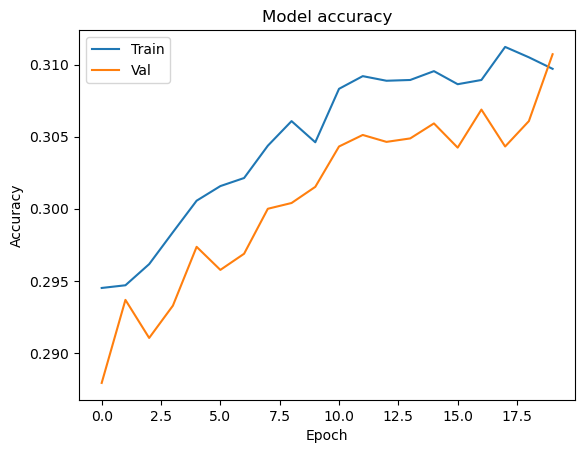

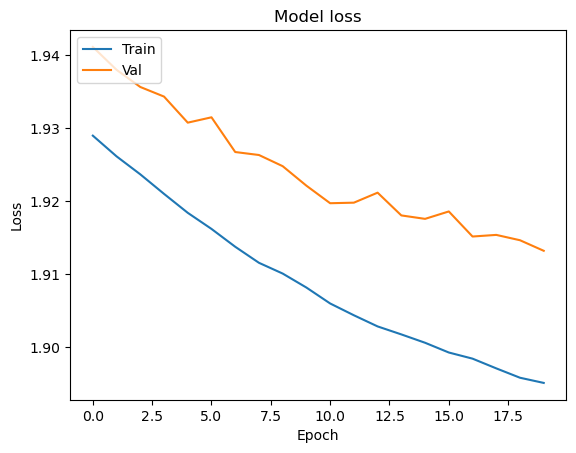

In [30]:
plot_history(history)

In [31]:
_, train_acc = model_features.evaluate(x_train_hist, y_train, verbose=1)
_, test_acc = model_features.evaluate(hist_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 2s 5ms/step - loss: 1.8986 - accuracy: 0.3167
Train: 0.312, Test: 0.317
